<a href="https://colab.research.google.com/github/newmantic/LSTM_options_hedge/blob/main/LSTM_options_hedge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy pandas tensorflow yfinance matplotlib scikit-learn

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Download historical stock price data (e.g., for SPY)
stock_data = yf.download('SPY', start='2010-01-01', end='2023-01-01')
vix_data = yf.download('^VIX', start='2010-01-01', end='2023-01-01')

# Prepare the dataset
data = pd.DataFrame()
data['Stock_Price'] = stock_data['Close']
data['VIX'] = vix_data['Close']  # Volatility index as a feature

# Drop rows with NaN values
data.dropna(inplace=True)

# Normalize the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare sequences for LSTM (lookback period)
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i, 0])  # Predict stock price
    return np.array(X), np.array(y)

lookback = 60  # 60-day lookback window
X, y = create_sequences(scaled_data, lookback)

# Reshape data for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# LSTM layer with 50 units and a dropout for regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (stock price prediction)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step - loss: 0.0242 - val_loss: 9.3626e-04
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 9.4167e-04 - val_loss: 0.0027
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 7.7484e-04 - val_loss: 0.0012
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 7.7963e-04 - val_loss: 0.0034
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 7.5236e-04 - val_loss: 5.9093e-04
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 7.7244e-04 - val_loss: 0.0065
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 7.3006e-04 - val_loss: 7.4691e-04
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 6.2992e-04 - val_loss: 0.0015
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - loss: 5.4602e-04 - val_loss: 0.0012
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 5.9543e-04 - val_loss: 5.4161e-04
Epoc

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


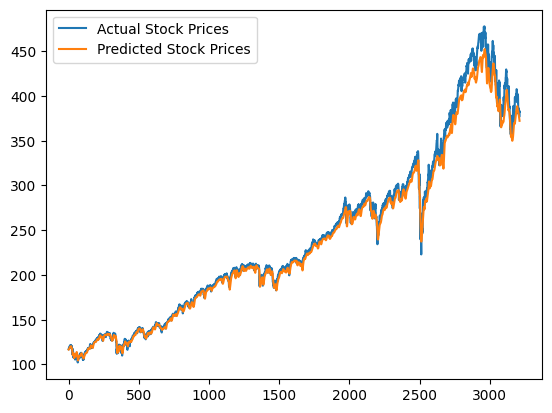

In [4]:
# Make predictions
predicted_stock_prices = model.predict(X)

# Inverse scale to get the actual stock prices
predicted_stock_prices = scaler.inverse_transform(np.concatenate((predicted_stock_prices, np.zeros((predicted_stock_prices.shape[0], 1))), axis=1))[:, 0]

# Actual stock prices for comparison
actual_stock_prices = scaler.inverse_transform(scaled_data)[lookback:, 0]

# Plot the results
import matplotlib.pyplot as plt

plt.plot(actual_stock_prices, label='Actual Stock Prices')
plt.plot(predicted_stock_prices, label='Predicted Stock Prices')
plt.legend()
plt.show()

In [5]:
# Simple rule-based hedging strategy based on predicted stock prices
def hedge_strategy(predicted_prices, actual_prices, threshold=0.05):
    actions = []
    for i in range(1, len(predicted_prices)):
        # Calculate percentage change in predicted prices
        pct_change = (predicted_prices[i] - predicted_prices[i-1]) / predicted_prices[i-1]

        if pct_change < -threshold:
            actions.append("Buy Put Option")  # Hedge against a downward trend
        elif pct_change > threshold:
            actions.append("Buy Call Option")  # Hedge for upward trend
        else:
            actions.append("Hold")  # Do nothing

    return actions

actions = hedge_strategy(predicted_stock_prices, actual_stock_prices)
for day, action in enumerate(actions[:10]):
    print(f"Day {day}: {action}")

Day 0: Hold
Day 1: Hold
Day 2: Hold
Day 3: Hold
Day 4: Hold
Day 5: Hold
Day 6: Hold
Day 7: Hold
Day 8: Hold
Day 9: Hold
